In [4]:
import mask
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import cartopy.crs as ccrs
import datetime
from cartoplot import cartoplot
import math
import cartopy
import cartopy.feature as cfea
import matplotlib
import matplotlib as mpl
import datetime

In [28]:
import matplotlib.dates as md

CryoSat-2
Sentinel-3A
Sentinel-3B


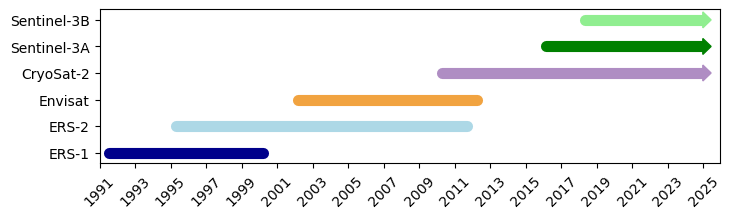

In [98]:
date_now = (2024,12,1)

colors = ['darkblue','lightblue','#f1a340','#af8dc3','green','lightgreen']


        
dt_now = datetime.date(date_now[0],date_now[1],date_now[2])
x0=md.date2num(dt_now-datetime.timedelta(days=200))
xw=md.date2num(dt_now+datetime.timedelta(days=20))-x0


tl_dict={
    'ERS-1':((1991,7,17),(2000,3,10)),
    'ERS-2':((1995,4,21),(2011,9,5)),
    'Envisat':((2002,3,1),(2012,4,8)),
    'CryoSat-2':((2010,4,8),date_now),
    'Sentinel-3A':((2016,2,16),date_now),
    'Sentinel-3B':((2018,4,25),date_now),
}

counter =-1
yticks = []

fig,ax = plt.subplots(1,1,figsize=(8,2))

for mission, (start,end) in tl_dict.items():
    counter+=1
    
    dt_start = datetime.date(start[0],start[1],start[2])
    dt_end = datetime.date(end[0],end[1],end[2])
    
    if end == date_now:

        ax.arrow(x=x0,y=counter,dx=xw,dy=0,width=0.1,zorder=10,
                 head_length=170,
                 head_width=0.6,color=colors[counter])
    
    ax.plot([dt_start,dt_end],[counter,counter],color=colors[counter],linewidth=8,solid_capstyle='round')
    
    yticks.append(mission)
    
ax.set_yticks(np.arange(0,6),yticks)

ax.set_xlim(datetime.date(1991,1,1),datetime.date(2025,12,1))
ax.set_ylim(-0.4,5.4)

xticks = [datetime.date(x,1,1) for x in np.arange(1991,2026,2)]
xticklabels = [x for x in np.arange(1991,2026,2)]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=45)
plt.show()

In [102]:
month_nums = np.arange(1,13)


output_dict = {}


for hem in ['SH','NH']:

    d = Dataset(f'../data/{hem}.nc')
    
    lat_grid = np.tile(np.array(d['latitude']),(d['longitude'].shape[0],1)).T

    lon_grid = np.tile(np.array(d['longitude']),(d['latitude'].shape[0],1))

    dt0 = datetime.date(1900,1,1)

    dts = [dt0 + datetime.timedelta(hours=int(d)) for d in d['time']]

    months = np.array([d.month for d in dts])

    years = np.array([d.year for d in dts])
    
    sic = np.array(d['siconc'])
    
    sic[sic<0] = np.nan
    sic[sic>1] = np.nan

    mar_sic = np.nanmean(sic[months==3],axis=0)
    sep_sic = np.nanmean(sic[months==9],axis=0)
    
    output_dict[hem] = {'mar':mar_sic,
                        'sep':sep_sic,
                        'lon':lon_grid,
                        'lat':lat_grid,}
    
#     break

/tmp/ipykernel_23835/1109380550.py:28: RuntimeWarning: Mean of empty slice
  mar_sic = np.nanmean(sic[months==3],axis=0)
/tmp/ipykernel_23835/1109380550.py:29: RuntimeWarning: Mean of empty slice
  sep_sic = np.nanmean(sic[months==9],axis=0)


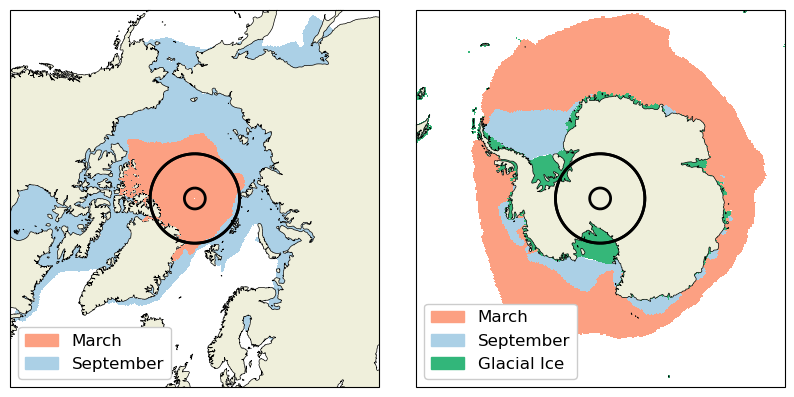

In [105]:
# Make the plot

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10, 5))

lat_limit=55

ax1.remove()
ax1 = fig.add_subplot(1,2,1,projection=ccrs.NorthPolarStereo())
ax2.remove()
ax2 = fig.add_subplot(1,2,2,projection=ccrs.SouthPolarStereo())

ax1.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=2,linewidth=0.5)
ax1.set_extent([-180, 180, 90, lat_limit], ccrs.PlateCarree())
# Annotate the Envisat and CS2 orbital limits

ax2.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=2,linewidth=0.5)
ax2.set_extent([-180, 180, -lat_limit, -90], ccrs.PlateCarree())
# Annotate the Envisat and CS2 orbital limits


orbitals = {'S3':81.35,
            'S3':81.46,
            'ERS2':81.46,
            'CS2':88,
            }

vals = np.array(list(orbitals.values()))

pmw_f = 'ice_conc_sh_polstere-100_multi_202204221200.nc'
pmw_d = Dataset(f'../data/conc.nc')
pmw_data = np.array(pmw_d['ice_conc'][0].copy())
pmw_data[pmw_data>0.5] = np.nan
pmw_data[pmw_data<0] = 1
pmw_data[pmw_data<0.5] = np.nan



ax2.plot([180, 180], [-90, -85],
         color=cfea.COLORS['land'],
         linewidth=4,
         transform=ccrs.PlateCarree(),
         zorder=2)


ax1.plot([180, 180], [65.5, 68.1],
         color=cfea.COLORS['land'],
         linewidth=3,
         transform=ccrs.PlateCarree(),
         zorder=2)

vmax = 3

bluecmap = mpl.colormaps['Blues']
b = bluecmap(1/vmax)
redcmap = mpl.colormaps['Reds']
r = redcmap(1/vmax)
vmap = mpl.colormaps['viridis']
p = vmap(0.66)

x=ax2.pcolormesh(pmw_d['lon'],pmw_d['lat'],pmw_data,vmin=0,vmax=1.5,transform=ccrs.PlateCarree())

dat = output_dict['NH']['mar']
dat[dat<0.5]=np.nan
dat[dat>0.1]=1
ax1.pcolormesh(output_dict['NH']['lon'],
               output_dict['NH']['lat'],
               dat,
                 vmin=0,vmax=vmax,transform=ccrs.PlateCarree(),alpha=1,cmap='Blues',zorder=1)

dat = output_dict['NH']['sep']
dat[dat<0.5]=np.nan
dat[dat>0.1]=1
ax1.pcolormesh(output_dict['NH']['lon'],
               output_dict['NH']['lat'],
               dat,
                 vmin=0,vmax=vmax,transform=ccrs.PlateCarree(),alpha=1,cmap='Reds',zorder=2)

dat = output_dict['SH']['sep']
dat[dat<0.5]=np.nan
dat[dat>0.1]=1
ax2.pcolormesh(output_dict['SH']['lon'],
               output_dict['SH']['lat'],
               dat,
                 vmin=0,vmax=vmax,transform=ccrs.PlateCarree(),alpha=1,cmap='Reds',zorder=1)

dat = output_dict['SH']['mar']
dat[dat<0.5]=np.nan
dat[dat>0.1]=1
ax2.pcolormesh(output_dict['SH']['lon'],
               output_dict['SH']['lat'],
               dat,
                 vmin=0,vmax=vmax,transform=ccrs.PlateCarree(),alpha=1,cmap='Blues',zorder=1)


ax1.gridlines(ylocs=vals,xlocs=[],color='k',linewidth=2,zorder=10)
ax2.gridlines(ylocs=-1*vals,xlocs=[],color='k',linewidth=2,zorder=10)

ax1.axvspan(xmin=np.nan,xmax=np.nan,color=r,label='March')
ax1.axvspan(xmin=np.nan,xmax=np.nan,color=b,label='September')

ax2.axvspan(xmin=np.nan,xmax=np.nan,color=r,label='March')
ax2.axvspan(xmin=np.nan,xmax=np.nan,color=b,label='September')
ax2.axvspan(xmin=np.nan,xmax=np.nan,color=p,label='Glacial Ice')

legend1=ax1.legend(loc='lower left',fontsize='large',facecolor='white', framealpha=1)
legend2=ax2.legend(loc='lower left',fontsize='large',facecolor='white', framealpha=1)




fig.subplots_adjust(wspace=0.1)

plt.savefig("poleholes.png", dpi=400,bbox_inches='tight')

plt.show()

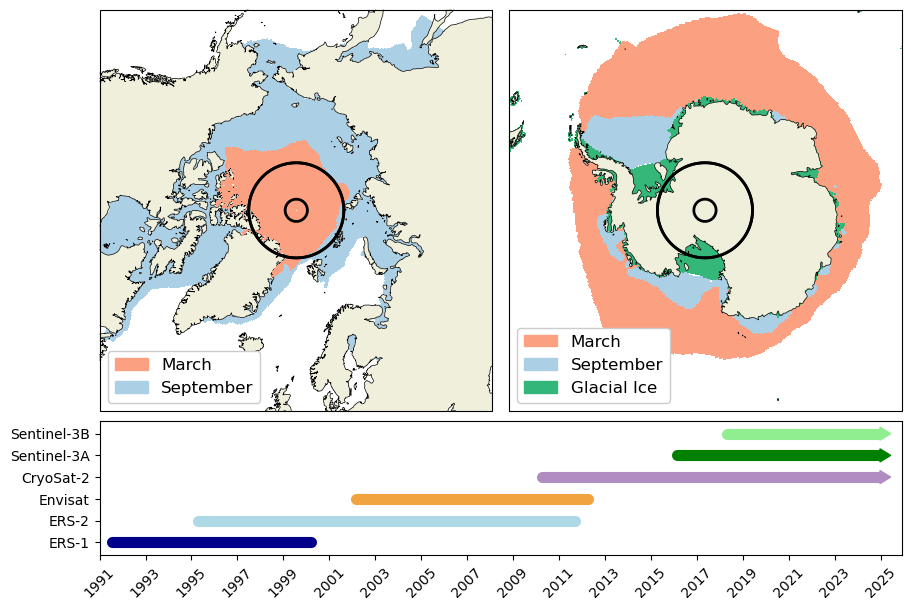

In [126]:
# Make the plot

fig3 = plt.figure(constrained_layout=True,figsize=(9,6))
gs = fig3.add_gridspec(8, 8)
ax1 = fig3.add_subplot(gs[:6,:4],projection=ccrs.NorthPolarStereo())
ax2 = fig3.add_subplot(gs[:6,4:],projection=ccrs.SouthPolarStereo())
ax3 = fig3.add_subplot(gs[6:,:])

lat_limit=55


ax1.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=2,linewidth=0.5)
ax1.set_extent([-180, 180, 90, lat_limit], ccrs.PlateCarree())
# Annotate the Envisat and CS2 orbital limits

ax2.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=2,linewidth=0.5)
ax2.set_extent([-180, 180, -lat_limit, -90], ccrs.PlateCarree())
# Annotate the Envisat and CS2 orbital limits


orbitals = {'S3':81.35,
            'S3':81.46,
            'ERS2':81.46,
            'CS2':88,
            }

vals = np.array(list(orbitals.values()))

pmw_f = 'ice_conc_sh_polstere-100_multi_202204221200.nc'
pmw_d = Dataset(f'../data/conc.nc')
pmw_data = np.array(pmw_d['ice_conc'][0].copy())
pmw_data[pmw_data>0.5] = np.nan
pmw_data[pmw_data<0] = 1
pmw_data[pmw_data<0.5] = np.nan



ax2.plot([180, 180], [-90, -85],
         color=cfea.COLORS['land'],
         linewidth=4,
         transform=ccrs.PlateCarree(),
         zorder=2)


ax1.plot([180, 180], [65.5, 68.1],
         color=cfea.COLORS['land'],
         linewidth=3,
         transform=ccrs.PlateCarree(),
         zorder=2)

vmax = 3

bluecmap = mpl.colormaps['Blues']
b = bluecmap(1/vmax)
redcmap = mpl.colormaps['Reds']
r = redcmap(1/vmax)
vmap = mpl.colormaps['viridis']
p = vmap(0.66)

x=ax2.pcolormesh(pmw_d['lon'],pmw_d['lat'],pmw_data,vmin=0,vmax=1.5,transform=ccrs.PlateCarree())

dat = output_dict['NH']['mar']
dat[dat<0.5]=np.nan
dat[dat>0.1]=1
ax1.pcolormesh(output_dict['NH']['lon'],
               output_dict['NH']['lat'],
               dat,
                 vmin=0,vmax=vmax,transform=ccrs.PlateCarree(),alpha=1,cmap='Blues',zorder=1)

dat = output_dict['NH']['sep']
dat[dat<0.5]=np.nan
dat[dat>0.1]=1
ax1.pcolormesh(output_dict['NH']['lon'],
               output_dict['NH']['lat'],
               dat,
                 vmin=0,vmax=vmax,transform=ccrs.PlateCarree(),alpha=1,cmap='Reds',zorder=2)

dat = output_dict['SH']['sep']
dat[dat<0.5]=np.nan
dat[dat>0.1]=1
ax2.pcolormesh(output_dict['SH']['lon'],
               output_dict['SH']['lat'],
               dat,
                 vmin=0,vmax=vmax,transform=ccrs.PlateCarree(),alpha=1,cmap='Reds',zorder=1)

dat = output_dict['SH']['mar']
dat[dat<0.5]=np.nan
dat[dat>0.1]=1
ax2.pcolormesh(output_dict['SH']['lon'],
               output_dict['SH']['lat'],
               dat,
                 vmin=0,vmax=vmax,transform=ccrs.PlateCarree(),alpha=1,cmap='Blues',zorder=1)


ax1.gridlines(ylocs=vals,xlocs=[],color='k',linewidth=2,zorder=10)
ax2.gridlines(ylocs=-1*vals,xlocs=[],color='k',linewidth=2,zorder=10)

ax1.axvspan(xmin=np.nan,xmax=np.nan,color=r,label='March')
ax1.axvspan(xmin=np.nan,xmax=np.nan,color=b,label='September')

ax2.axvspan(xmin=np.nan,xmax=np.nan,color=r,label='March')
ax2.axvspan(xmin=np.nan,xmax=np.nan,color=b,label='September')
ax2.axvspan(xmin=np.nan,xmax=np.nan,color=p,label='Glacial Ice')

legend1=ax1.legend(loc='lower left',fontsize='large',facecolor='white', framealpha=1)
legend2=ax2.legend(loc='lower left',fontsize='large',facecolor='white', framealpha=1)

counter =-1
yticks = []

for mission, (start,end) in tl_dict.items():
    counter+=1
    
    dt_start = datetime.date(start[0],start[1],start[2])
    dt_end = datetime.date(end[0],end[1],end[2])
    
    if end == date_now:

        ax3.arrow(x=x0,y=counter,dx=xw,dy=0,width=0.1,zorder=10,
                 head_length=170,
                 head_width=0.6,color=colors[counter])
    
    ax3.plot([dt_start,dt_end],[counter,counter],color=colors[counter],linewidth=8,solid_capstyle='round')
    
    yticks.append(mission)
    
ax3.set_yticks(np.arange(0,6),yticks)

ax3.set_xlim(datetime.date(1991,1,1),datetime.date(2025,12,1))
ax3.set_ylim(-0.6,5.6)

xticks = [datetime.date(x,1,1) for x in np.arange(1991,2026,2)]
xticklabels = [x for x in np.arange(1991,2026,2)]
ax3.set_xticks(xticks)
ax3.set_xticklabels(xticklabels,rotation=45)


fig.subplots_adjust(wspace=0.1,hspace=0.1)

plt.savefig("poleholes_timeline.png", dpi=600,bbox_inches='tight')

plt.show()